In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import glob
from scipy.stats import ks_2samp, kstest
%matplotlib inline

In [2]:
def load_summary(filename):
    dtype=[('minr', 'f8'),
           ('maxr', 'f8'), 
           ('ca_ratio', 'f8'),
           ('ba_ratio', 'f8'),
           ('a', 'f8'),
           ('center', 'f8'),
           ('width', 'f8'),
           ('mu', 'f8')]
    summary = np.loadtxt(filename, dtype=dtype)    
    return summary

In [3]:
def load_experiment(input_path="../data/mstar_selected_summary/vmax_sorted/", fixed_number=False, full_data=False):
    files = glob.glob(input_path+"M31_group_*")
    group_id = []
    for f in files:
        i = int(f.split("_")[-5])
        if i not in group_id:
            group_id.append(i)
    print(group_id, len(group_id))

    n_groups = len(group_id)

    if fixed_number:
        n_iter = np.arange(5)
    else:
        n_iter = np.arange(11,16)
    
    fields = ['width','mu', 'a', 'ba_ratio', 'ca_ratio']
    M31_all = {}
    MW_all = {}
    if not full_data:
        for field in fields:
            M31_all[field] = np.ones(n_groups)
            MW_all[field] = np.ones(n_groups)
            M31_all[field+'_sigma'] = np.ones(n_groups)
            MW_all[field+'_sigma'] = np.ones(n_groups)
        
            M31_all[field+'_random'] = np.ones(n_groups)
            MW_all[field+'_random'] = np.ones(n_groups)
            M31_all[field+'_random_sigma'] = np.ones(n_groups)
            MW_all[field+'_random_sigma'] = np.ones(n_groups)
    else:
        for field in fields:
            M31_all[field] = np.empty((0))
            MW_all[field] = np.empty((0))
            M31_all[field+'_random'] = np.empty((0))
            MW_all[field+'_random'] = np.empty((0))
           

    for g in range(n_groups):

        MW_summary = {}
        M31_summary = {}
    
        for i in n_iter:
            if fixed_number:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], 11, i))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g],11, i))
            else:
                filename_MW = os.path.join(input_path,"MW_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))
                filename_M31 = os.path.join(input_path,"M31_group_{}_nmax_{}_iter_{}.dat".format(group_id[g], i, 0))

            MW_summary[i] = load_summary(filename_MW)
            M31_summary[i] = load_summary(filename_M31)
    
        
        for field in fields:
            a = np.empty((0))
            b = np.empty((0))
            a_random = np.empty((0))
            b_random = np.empty((0))
        
            for i in n_iter:
                data = M31_summary[i]
                a = np.append(a, data[field][0])
                a_random = np.append(a_random, data[field][1:101])
        
                data = MW_summary[i]
                b = np.append(b, data[field][0])
                b_random = np.append(b_random, data[field][1:101])
                #print('a_random {} iter: {} {}'.format(field, i, a_random))
                
            if not full_data:
                M31_all[field][g] = np.average(a)
                MW_all[field][g] = np.average(b)
                M31_all[field+'_sigma'][g] = np.std(a)
                MW_all[field+'_sigma'][g] = np.std(b)
                M31_all[field+'_random'][g] = np.average(a_random)
                MW_all[field+'_random'][g] = np.average(b_random)
                M31_all[field+'_random_sigma'][g] = np.std(a_random)
                MW_all[field+'_random_sigma'][g] = np.std(b_random)
            else:
                M31_all[field] = np.append(M31_all[field], a)
                MW_all[field] = np.append(MW_all[field], b)
                M31_all[field+'_random'] = np.append(M31_all[field+'_random'], a_random)
                MW_all[field+'_random'] = np.append(MW_all[field+'_random'], b_random)
                
    return M31_all, MW_all

In [4]:
in_path = "../data/obs_summary/vmag_random/"
M31_obs_vmag_random_full, MW_obs_vmag_random_full = load_experiment(input_path=in_path, fixed_number=True, full_data=True)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full = load_experiment(input_path=in_path, fixed_number=False, full_data=True)

in_path = "../data/obs_summary/vmag_random/"
M31_obs_vmag_random, MW_obs_vmag_random = load_experiment(input_path=in_path, fixed_number=True, full_data=False)

in_path = "../data/obs_summary/vmag_sorted/"
M31_obs_vmag_sorted, MW_obs_vmag_sorted = load_experiment(input_path=in_path, fixed_number=False, full_data=False)



[0] 1
[0] 1
[0] 1
[0] 1


In [5]:
in_path = "../data/illustris1_mstar_selected_summary/vmax_random/"
M31_sim_vmax_random, MW_sim_vmax_random= load_experiment(input_path=in_path, fixed_number=True)
in_path = "../data/illustris1_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted, MW_sim_vmax_sorted = load_experiment(input_path=in_path, fixed_number=False)


[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20
[0, 10, 11, 13, 14, 16, 18, 1, 20, 21, 22, 24, 25, 2, 3, 4, 5, 6, 8, 9] 20


In [6]:
in_path = "../data/illustris1dark_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm = load_experiment(input_path=in_path, fixed_number=False)

[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1, 20, 21, 22, 23, 25, 2, 3, 4, 5, 6, 7, 8, 9] 24


In [7]:
in_path = "../data/elvis_mstar_selected_summary/vmax_sorted/"
M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis = load_experiment(input_path=in_path, fixed_number=False)

[0, 10, 11, 1, 2, 3, 4, 5, 6, 7, 8, 9] 12


In [8]:
def plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
                    M31_sim_vmax_sorted, MW_sim_vmax_sorted, field = 'mu', title='ranked'):
    label_obs = "Obs."
    label_sim = "Sim."
    label = {'mu': 'Normalized $\\mu$',
         'ca_ratio': 'Normalized c/a', 
         'ba_ratio': 'Normalized b/a',
         'width':'Normalized width'}
             
    fig = plt.figure(1, figsize=(7,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)

    x_obs = (M31_obs_vmag_sorted[field] - M31_obs_vmag_sorted[field+'_random'])/M31_obs_vmag_sorted[field+'_random_sigma']
    y_obs = (MW_obs_vmag_sorted[field] - MW_obs_vmag_sorted[field+'_random'])/MW_obs_vmag_sorted[field+'_random_sigma']

    x_err = (M31_obs_vmag_sorted[field+'_sigma'] )/M31_obs_vmag_sorted[field+'_random_sigma']
    y_err = (MW_obs_vmag_sorted[field+'_sigma'])/MW_obs_vmag_sorted[field+'_random_sigma']

    plt.errorbar(x_obs, y_obs, xerr=x_err, yerr=y_err,
                fmt='*', markersize=30, color='black', alpha=0.9, label=label_obs)
    

    x_sim = (M31_sim_vmax_sorted[field] - M31_sim_vmax_sorted[field+'_random'])/M31_sim_vmax_sorted[field+'_random_sigma']
    y_sim = (MW_sim_vmax_sorted[field] - MW_sim_vmax_sorted[field+'_random'])/MW_sim_vmax_sorted[field+'_random_sigma']
    x_err = (M31_sim_vmax_sorted[field+'_sigma'])/M31_sim_vmax_sorted[field+'_random_sigma']
    y_err = (MW_sim_vmax_sorted[field+'_sigma'])/MW_sim_vmax_sorted[field+'_random_sigma']

    
    plt.errorbar(x_sim, y_sim, xerr=x_err, yerr=y_err,
                fmt='o', markersize=10, color='black', alpha=0.5, label=label_sim)

    print('KS2 field {}, KS {}'.format(field, ks_2samp(x_sim, y_sim)))
    print('M31 KS uniform field {}, KS {}'.format(field, kstest(x_sim, "uniform")))
    print('M31 KS normal field {}, KS {}'.format(field, kstest(x_sim, "norm")))
    print('MW KS uniform field {}, KS {}'.format(field, kstest(y_sim, "uniform")))
    print('MW KS normal field {}, KS {}'.format(field, kstest(y_sim, "norm")))

 


    plt.ylabel('MW '+label[field])
    plt.xlabel('M31 '+label[field])
    x = np.linspace(-3.0,3.0,5)
    plt.plot(x,x, color='black', linewidth=1.0, alpha=0.4)
    plt.xticks(np.arange(-4,4))
    plt.xlim([-3,3])
    plt.ylim([-3,3])
    plt.legend(loc=2, prop={'size': 20})
    plt.axes().set_aspect('equal')

    filename = "../paper/scatter_norm_{}_{}.pdf".format(title, field)
    plt.savefig(filename, bbox_inches='tight')

In [8]:
def gauss(x,mean,sigma):
    return 0.5*((x-mean)/sigma)**2.0

def power(x,alpha,sigma):
    return -np.log(alpha*(x+1E-8)**(alpha-1.0))
#    return -np.log(alpha * x + (1.0 - 0.5*alpha))

def get_distro(full_data, field, min_alpha, max_alpha, min_support, max_support, p_func=None, n_alpha=300, random=False):
    alpha = np.linspace(min_alpha, max_alpha, n_alpha)
    p_alpha_data = np.zeros(n_alpha)
    
    if random:
        data = full_data[field+'_random']
    else:
        data = full_data[field]
    sigma = np.std(data)
    mean = np.mean(data)
    n_points =  len(data)
  
    print('n_points {}'.format(n_points))
    for i in range(n_alpha):
        for j in range(n_points):
            p_alpha_data[i] += p_func(data[j], alpha[i], sigma)
            #if i==0:
            #    print('dat', p_alpha_data[i], data[j], p_func(data[j], alpha[i], sigma))
                
    #print(p_alpha_data, data)
    p_alpha_data = p_alpha_data - np.min(p_alpha_data)
    p_alpha_data = np.exp(-p_alpha_data)
    norm_data = np.trapz(p_alpha_data, x=alpha)
    
    max_alpha = alpha[np.argmax(p_alpha_data)]
    #plt.plot(alpha, p_alpha_data)

    print('max alpha {}'.format(max_alpha))
    x = np.linspace(min_support, max_support, 300)
    p_x_theory = np.exp(-p_func(x, max_alpha, sigma))
    norm_p_x = np.trapz(p_x_theory, x=x)
    return alpha, p_alpha_data/norm_data, x, p_x_theory/norm_p_x

In [9]:
def scatter_plot(M31_obs, MW_obs, M31_sim, MW_sim, 
                 field='mu', title='', 
                 label_obs='Obs. ', label_sim='Sim.',
                 random=False, put_legend=False):
    xrange = {'mu':[0.0,1], 'ca_ratio':[0.1, 0.9], 'ba_ratio':[0.45, 1.0], 'width':[0,120]}
    yrange = {'mu':[0.0,1], 'ca_ratio':[0.1, 0.9], 'ba_ratio':[0.45, 1.0], 'width':[0,120]}
    location = {'mu':[4,4], 'ca_ratio':[2, 2], 'ba_ratio':[3, 3], 'width':[2,2]}
    label = {'mu':'$\mu$', 'ca_ratio':'c/a', 'ba_ratio':'b/a', 'width':'plane width [kpc]'}
    
    x = np.linspace(-1.0,200,5)
    fig = plt.figure(1, figsize=(7,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)

    #plt.title(title)
    if random:
        plt.errorbar(M31_obs[field], MW_obs[field],
                 fmt='*', markersize=30, color='black', alpha=0.9, label=label_obs)
        plt.errorbar(M31_sim[field+'_random'], MW_sim[field+'_random'],
                 fmt='o', markersize=4, color='black', alpha=0.2, label=label_sim)  
    else:
        plt.errorbar(M31_obs[field], MW_obs[field],
                 xerr=M31_obs[field+'_sigma'], yerr=MW_obs[field+'_sigma'], 
                 fmt='*', markersize=30, color='black', alpha=0.9, label=label_obs)
        plt.errorbar(M31_sim[field], MW_sim[field],
                 xerr=M31_sim[field+'_sigma'], yerr=MW_sim[field+'_sigma'], 
                 fmt='o', markersize=10, color='black', alpha=0.5, label=label_sim)
    
    
    plt.plot(x,x, color='black', linewidth=1.0, alpha=0.4)
    
    print('type {}, field {}, KS {}'.format(title, field, ks_2samp(M31_sim[field], MW_sim[field])))
    
    if put_legend:
        plt.legend(loc=location[field][0], prop={'size': 20})

    plt.xlim(xrange[field])
    plt.ylim(yrange[field])
    plt.xlabel('M31 '+label[field])
    plt.ylabel('MW '+label[field])
    plt.tight_layout()
    plt.axes().set_aspect('equal')

    if random:
        filename = "../paper/scatter_random_{}_{}.pdf".format(title, field)
    else:
        filename = "../paper/scatter_{}_{}.pdf".format(title, field)

    plt.savefig(filename, bbox_inches='tight')


In [10]:
def distribution_plot(M31_obs_full, MW_obs_full, M31_sim, MW_sim, 
                      label_sim_M31='Sim. M31', label_sim_MW='Sim. MW',
                      field='', title='', random=False, put_legend=False):
    xrange = {'mu':[1E-3,1.99], 'ca_ratio':[0.65, 0.8], 'ba_ratio':[0.86, 0.93], 'width':[50,80]}
    support = {'mu':[1E-2,1.0], 'ca_ratio':[0.45, 1.0], 'ba_ratio':[0.75, 1.0], 'width':[10,110]}
    location = {'mu':[3,3], 'ca_ratio':[1, 1], 'ba_ratio':[2, 2], 'width':[2,2]}
    label = {'mu':'$\\mu$', 'ca_ratio':'c/a', 
             'ba_ratio':'b/a', 'width':'plane width [kpc]'}
    distro = {'mu': power, 'ca_ratio':gauss, 'ba_ratio':gauss, 'width':gauss}
   
    fig = plt.figure(1, figsize=(7,6))
    plt.rc('text', usetex=True,)
    plt.rc('font', family='serif', size=25)

    
    plt.title(title)
    
    alpha_M31, p_alpha_M31, x_M31, p_th_M31 = get_distro(M31_sim, field, 
                                                         xrange[field][0], xrange[field][1],
                                                         support[field][0], support[field][1],
                                                         p_func=distro[field], random=random)
    alpha_MW, p_alpha_MW, x_MW, p_th_MW = get_distro(MW_sim, field, 
                                                     xrange[field][0], xrange[field][1], 
                                                     support[field][0], support[field][1],
                                                     p_func=distro[field], random=random)
    
    plt.plot(x_M31, p_th_M31, label=label_sim_M31, linewidth=3, color='black')
    plt.plot(x_MW, p_th_MW, "--", label=label_sim_MW, linewidth=3, color='black')
    
   # plt.hist(M31_sim_rand[field], normed=True)
   # plt.hist(MW_sim_rand[field], normed=True)
    
    m = np.mean(M31_obs_full[field])
    s = np.std(M31_obs_full[field])
    plt.axvspan(m-s, m+s, alpha=0.5, color='black', label="Obs. M31")
    m = np.mean(MW_obs_full[field])
    s = np.std(MW_obs_full[field])
    plt.axvspan(m-s, m+s,alpha=0.2, color='black', label="Obs. MW")
    
    if field=='mu' :
        plt.ylim([0,1.4]) 

    if put_legend:
        plt.legend(loc=location[field][0], prop={'size': 20})
        
    plt.xlim(support[field])
    plt.xlabel(label[field])
    plt.ylabel(r"P({}, data)".format(label[field]))

    if random:
        filename = "../paper/distro_random_{}_{}.pdf".format(title, field)
    else:
        filename = "../paper/distro_{}_{}.pdf".format(title, field)
    plt.savefig(filename, bbox_inches='tight')


type ranked, field width, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


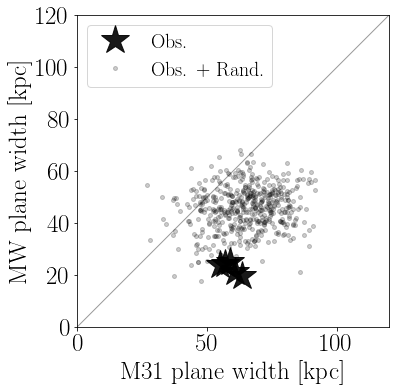

In [11]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='width', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=True,
             random=True)

type ranked, field mu, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


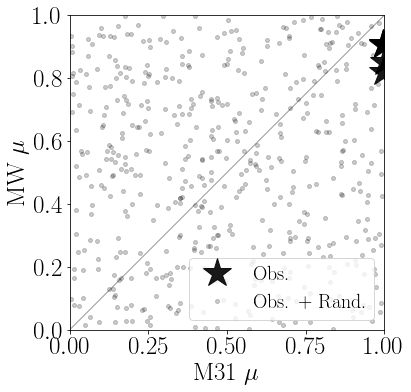

In [12]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='mu', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=True,
             random=True)

type ranked, field ca_ratio, KS Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


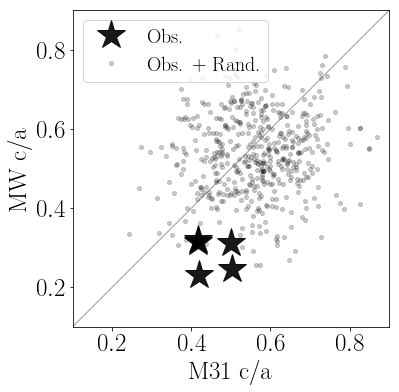

In [32]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='ca_ratio', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=True,
             random=True)

type ranked, field ba_ratio, KS Ks_2sampResult(statistic=0.59999999999999998, pvalue=0.20898483057516717)


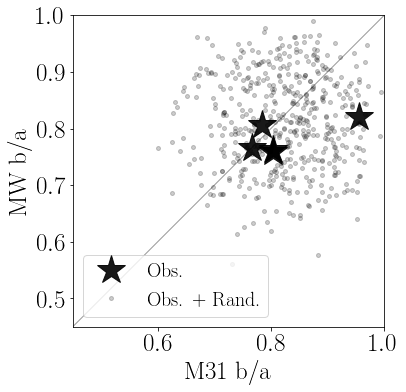

In [33]:
scatter_plot(M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             M31_obs_vmag_sorted_full, MW_obs_vmag_sorted_full, 
             field='ba_ratio', title='ranked', 
             label_obs='Obs.', label_sim='Obs.  + Rand.',
             put_legend=True,
             random=True)

type ranked, field width, KS Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)


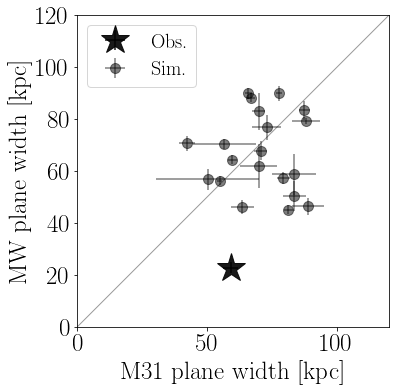

In [10]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=True,
             field='width', title='ranked')

type ranked_illudm, field width, KS Ks_2sampResult(statistic=0.24999999999999994, pvalue=0.38728086223204417)


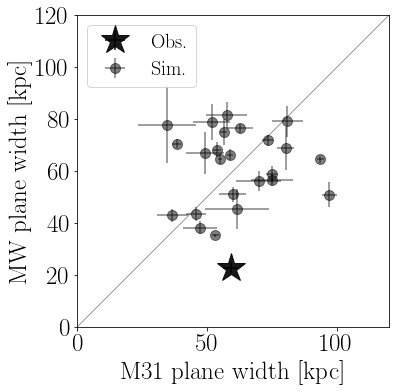

In [12]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm, 
             put_legend=True,
             field='width', title='ranked_illudm')

type ranked_elvis, field width, KS Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)


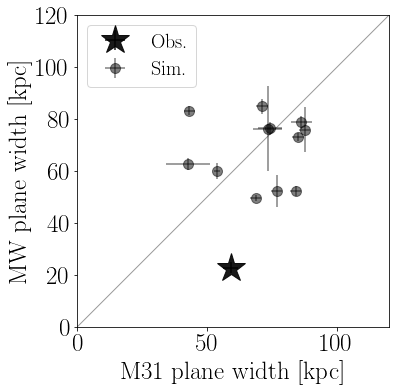

In [13]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis, 
             put_legend=True,
             field='width', title='ranked_elvis')

type ranked, field mu, KS Ks_2sampResult(statistic=0.29999999999999999, pvalue=0.27526886726742134)


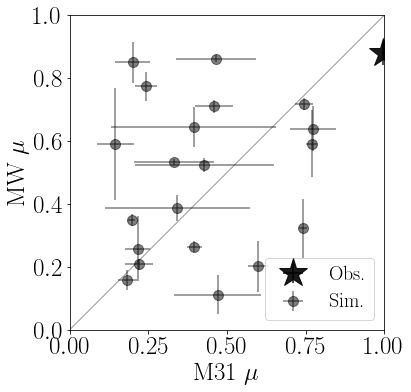

In [36]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=True,
             field='mu', title='ranked')

type ranked_elvis, field mu, KS Ks_2sampResult(statistic=0.16666666666666674, pvalue=0.99133252540492101)


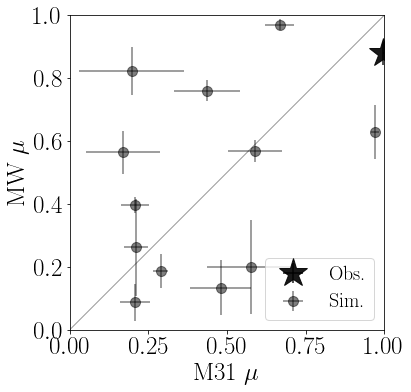

In [37]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis, 
             put_legend=True,
             field='mu', title='ranked_elvis')

type ranked, field ca_ratio, KS Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)


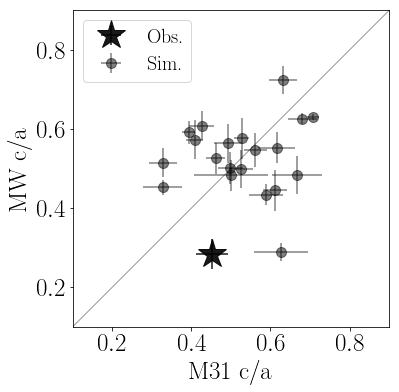

In [38]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=True,
             field='ca_ratio', title='ranked')

type ranked_elvis, field ca_ratio, KS Ks_2sampResult(statistic=0.33333333333333331, pvalue=0.43330893681048638)


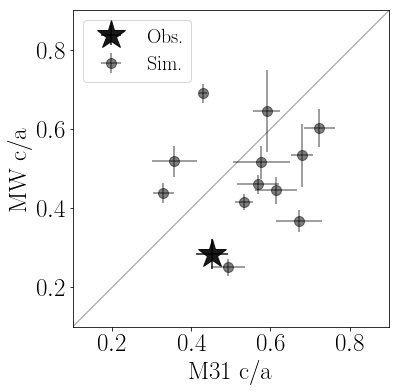

In [39]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis, 
             put_legend=True,
             field='ca_ratio', title='ranked_elvis')

type ranked_illudm, field ca_ratio, KS Ks_2sampResult(statistic=0.16666666666666674, pvalue=0.86076435166066956)


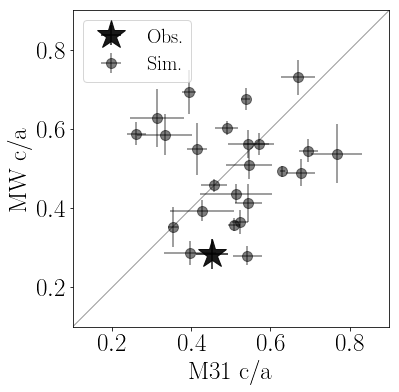

In [14]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm, 
             put_legend=True,
             field='ca_ratio', title='ranked_illudm')

type ranked, field ba_ratio, KS Ks_2sampResult(statistic=0.15000000000000002, pvalue=0.96548474089861591)


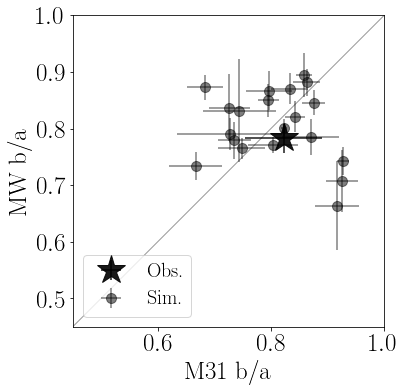

In [40]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted, 
             put_legend=True,
             field='ba_ratio', title='ranked')

type ranked_elvis, field ba_ratio, KS Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)


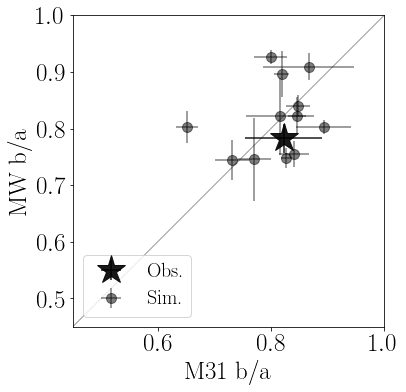

In [41]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis, 
             put_legend=True,
             field='ba_ratio', title='ranked_elvis')

type ranked_illudm, field ba_ratio, KS Ks_2sampResult(statistic=0.29166666666666669, pvalue=0.21597687808564428)


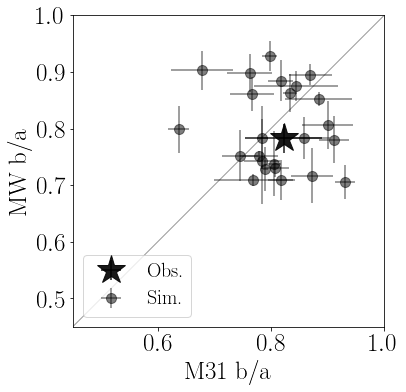

In [15]:
scatter_plot(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm, 
             put_legend=True,
             field='ba_ratio', title='ranked_illudm')

KS2 field mu, KS Ks_2sampResult(statistic=0.29999999999999999, pvalue=0.27526886726742134)
M31 KS uniform field mu, KS KstestResult(statistic=0.75, pvalue=3.7636560534792807e-12)
M31 KS normal field mu, KS KstestResult(statistic=0.28463353636333, pvalue=0.063017244813583062)
MW KS uniform field mu, KS KstestResult(statistic=0.45000000000000001, pvalue=0.00032446411409559062)
MW KS normal field mu, KS KstestResult(statistic=0.11318258667180636, pvalue=0.95986246783717954)


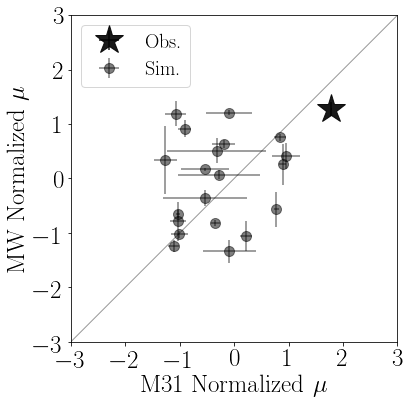

In [42]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted,
                field='mu', title='ranked')

KS2 field mu, KS Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)
M31 KS uniform field mu, KS KstestResult(statistic=0.66666666666666663, pvalue=8.8386191314793194e-06)
M31 KS normal field mu, KS KstestResult(statistic=0.25561318699451541, pvalue=0.35329621429718494)
MW KS uniform field mu, KS KstestResult(statistic=0.5, pvalue=0.0026802516560560097)
MW KS normal field mu, KS KstestResult(statistic=0.23196149219016854, pvalue=0.47429525460094757)


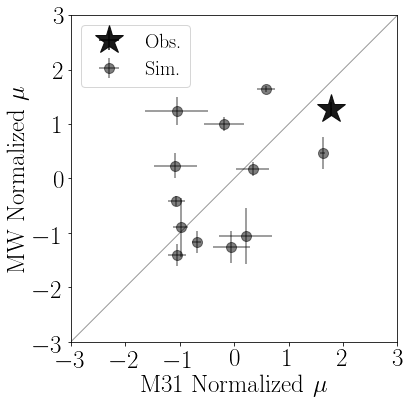

In [43]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis,
                field='mu', title='ranked_elvis')

KS2 field ca_ratio, KS Ks_2sampResult(statistic=0.25, pvalue=0.4973423353136131)
M31 KS uniform field ca_ratio, KS KstestResult(statistic=0.59999999999999998, pvalue=2.048301164236932e-07)
M31 KS normal field ca_ratio, KS KstestResult(statistic=0.23720320132726558, pvalue=0.1789384722440388)
MW KS uniform field ca_ratio, KS KstestResult(statistic=0.72939088249442074, pvalue=2.2489787809831796e-11)
MW KS normal field ca_ratio, KS KstestResult(statistic=0.30471861595038841, pvalue=0.038153662345048467)


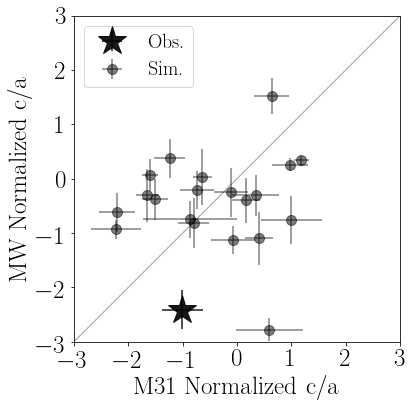

In [44]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted,
                field='ca_ratio', title='ranked')

KS2 field ca_ratio, KS Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.43330893681048599)
M31 KS uniform field ca_ratio, KS KstestResult(statistic=0.58333333333333337, pvalue=0.00020759026288930116)
M31 KS normal field ca_ratio, KS KstestResult(statistic=0.18160259798006212, pvalue=0.82358602327790842)
MW KS uniform field ca_ratio, KS KstestResult(statistic=0.75, pvalue=1.7028946786012966e-07)
MW KS normal field ca_ratio, KS KstestResult(statistic=0.35833634704649941, pvalue=0.069379100928886661)


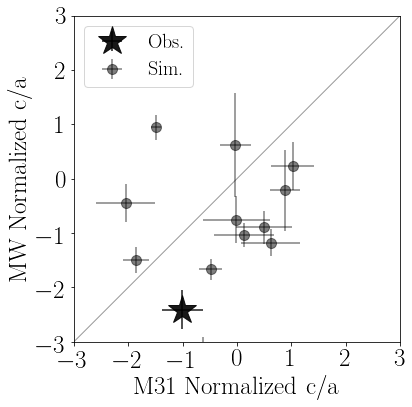

In [45]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis,
                field='ca_ratio', title='ranked_elvis')

KS2 field ca_ratio, KS Ks_2sampResult(statistic=0.08333333333333337, pvalue=0.99998955420390534)
M31 KS uniform field ca_ratio, KS KstestResult(statistic=0.75, pvalue=1.7763568394002505e-14)
M31 KS normal field ca_ratio, KS KstestResult(statistic=0.30561429213839902, pvalue=0.017369142677952532)
MW KS uniform field ca_ratio, KS KstestResult(statistic=0.67888746160578706, pvalue=1.7298162902079639e-11)
MW KS normal field ca_ratio, KS KstestResult(statistic=0.2411473735871601, pvalue=0.10314376969149452)


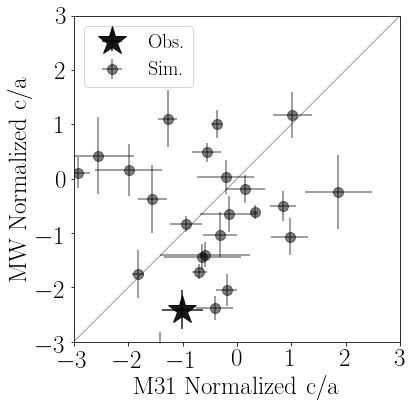

In [16]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm,
                field='ca_ratio', title='ranked_illudm')

KS2 field ba_ratio, KS Ks_2sampResult(statistic=0.19999999999999998, pvalue=0.77095294467658682)
M31 KS uniform field ba_ratio, KS KstestResult(statistic=0.55000000000000004, pvalue=3.2861970662434459e-06)
M31 KS normal field ba_ratio, KS KstestResult(statistic=0.1930908370233278, pvalue=0.39716888840272491)
MW KS uniform field ba_ratio, KS KstestResult(statistic=0.55000000000000004, pvalue=3.2861970662434459e-06)
MW KS normal field ba_ratio, KS KstestResult(statistic=0.20253888233779127, pvalue=0.33948365404552217)


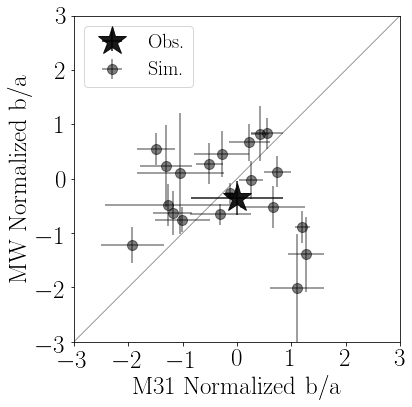

In [46]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted,
                field='ba_ratio', title='ranked')

KS2 field ba_ratio, KS Ks_2sampResult(statistic=0.25, pvalue=0.78641716217514468)
M31 KS uniform field ba_ratio, KS KstestResult(statistic=0.58333333333333337, pvalue=0.00020759026288930116)
M31 KS normal field ba_ratio, KS KstestResult(statistic=0.22082720073827378, pvalue=0.53986147575882582)
MW KS uniform field ba_ratio, KS KstestResult(statistic=0.70025532028543258, pvalue=2.0116908441281112e-06)
MW KS normal field ba_ratio, KS KstestResult(statistic=0.23016292562374907, pvalue=0.48450708238162488)


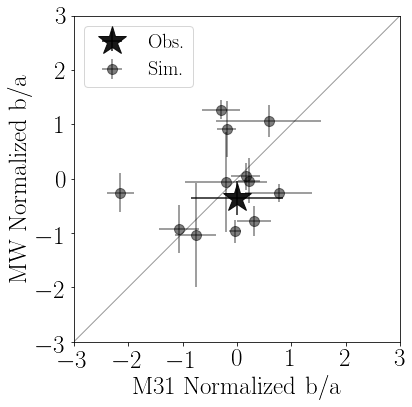

In [47]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis,
                field='ba_ratio', title='ranked_elvis')

KS2 field ba_ratio, KS Ks_2sampResult(statistic=0.29166666666666669, pvalue=0.21597687808564428)
M31 KS uniform field ba_ratio, KS KstestResult(statistic=0.59100002971316068, pvalue=1.6156000537392856e-08)
M31 KS normal field ba_ratio, KS KstestResult(statistic=0.14077120014506328, pvalue=0.70656545007941451)
MW KS uniform field ba_ratio, KS KstestResult(statistic=0.625, pvalue=1.3777914364965227e-09)
MW KS normal field ba_ratio, KS KstestResult(statistic=0.25991934961743557, pvalue=0.064240414106855992)


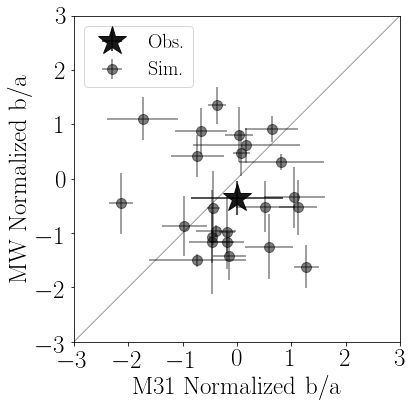

In [17]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm,
                field='ba_ratio', title='ranked_illudm')

KS2 field width, KS Ks_2sampResult(statistic=0.20000000000000001, pvalue=0.77095294467658682)
M31 KS uniform field width, KS KstestResult(statistic=0.59999999999999998, pvalue=2.048301164236932e-07)
M31 KS normal field width, KS KstestResult(statistic=0.23345967616789465, pvalue=0.19269397401053556)
MW KS uniform field width, KS KstestResult(statistic=0.5, pvalue=3.7875952405341806e-05)
MW KS normal field width, KS KstestResult(statistic=0.17598267275416668, pvalue=0.51779711560089492)


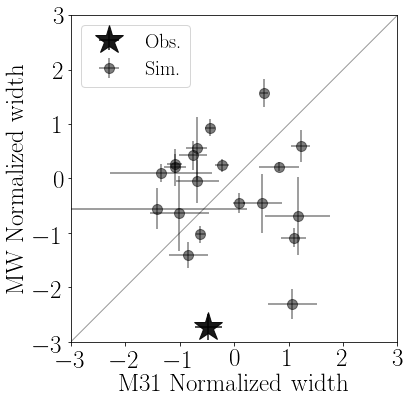

In [48]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted, MW_sim_vmax_sorted,
                field='width', title='ranked')

KS2 field width, KS Ks_2sampResult(statistic=0.41666666666666669, pvalue=0.186196839004176)
M31 KS uniform field width, KS KstestResult(statistic=0.41666666666666669, pvalue=0.021146766201908251)
M31 KS normal field width, KS KstestResult(statistic=0.17475759551925951, pvalue=0.85708240314842044)
MW KS uniform field width, KS KstestResult(statistic=0.69827542440176904, pvalue=2.2035703968192877e-06)
MW KS normal field width, KS KstestResult(statistic=0.29318142478368658, pvalue=0.20800401225788656)


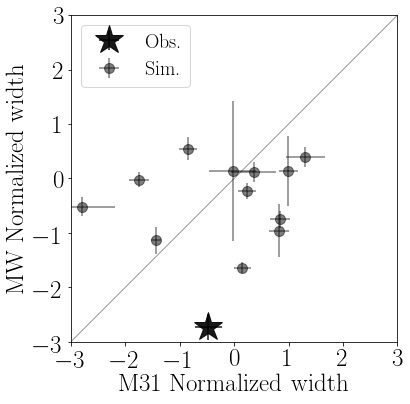

In [49]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_elvis, MW_sim_vmax_sorted_elvis,
                field='width', title='ranked_elvis')

KS2 field width, KS Ks_2sampResult(statistic=0.16666666666666663, pvalue=0.86076435166067)
M31 KS uniform field width, KS KstestResult(statistic=0.58333333333333337, pvalue=2.7343700859105979e-08)
M31 KS normal field width, KS KstestResult(statistic=0.19232919328856629, pvalue=0.29831249206638866)
MW KS uniform field width, KS KstestResult(statistic=0.7270171891619619, pvalue=1.9251267247000214e-13)
MW KS normal field width, KS KstestResult(statistic=0.24578743567208411, pvalue=0.092064578779561979)


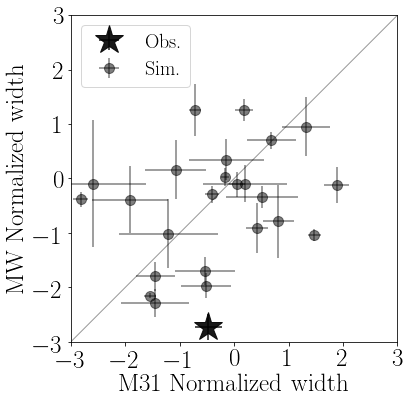

In [18]:
plot_normalized(M31_obs_vmag_sorted, MW_obs_vmag_sorted, 
             M31_sim_vmax_sorted_illudm, MW_sim_vmax_sorted_illudm,
                field='width', title='ranked_illudm')